
# Computational Statistics for Data Analysis (part II)


> Statistics is the discipline of using data samples to support claims about populations.

Statistics is based on 2 main concepts:

* A **population** is a collection of objects, items (“units”) about which information is sought.

* A **sample** is a part of the population that is observed.

# Index

###1 Data preparation.
* 1.1 Getting data
* 1.2 Improving data as a pandas DataFrame
* 1.3 Data cleaning and preparation
 

###2 Exploratory Data Analysis.
* 2.1 Summarizing the data: mean, variance, median, quantiles & percentiles
* 2.2 Histogram
* 2.3 Data distributions
* 2.3.1 PMF
* 2.3.2 CDF
* 2.4 Outliers
* 2.5 Measuring asymmetry
* 2.6 Relative risk

### "Do firts babies arrive late?"

Some people believe it is true, but **without data analysis** to support it, this claim is a case of **anecdotal evidence**:

* There are a **small number of samples** (personal experience, friends, etc.).
* There is a **selection bias**: most *believers* are interested in this claim because their first babies were late.
* There is a **confirmation bias**: believers might be more likely to contribute data that confirm it.
* Sources are **innaccurate**: personal stories are subject to memory deformations. 



# 1 Data preparation.

## 1.1 Getting Data

There is an interesting and publicly available **data source** to check this claim. Since 1973 the U.S. Centers for Disease Control and Prevention (CDC) have conducted a survey, the National Survey of Family Growth (NSFG), to gather *information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men's and women's health.* 

Data can be downloaded from: 

http://www.cdc.gov/nchs/nsfg/nsfg_cycle6.htm#cyc6downdatafiles

We will use this file: 

* Female Pregnancy Data File (2002FemPreg.dat): one record for each pregnancy reported by a respondent.

There are 13593 pregnancies in our data. The meaning of the data is (each record is in a line):

+ <code>case.id</code> is the ID of the respondent. From col 1 to 12.
+ <code>prg.length</code> is the duration of the pregnancy in weeks. From col 275 to 276. 
+ <code>outcome</code> is the outcome of the pregnancy (1 = live birth). Col 277.
+ <code>birth.ord</code> is the integer birth order of each live birth. From col 278 to 279.
+ <code>final.wgt</code> is the statistical weight associated to the respondent (it is a floating point value that indicates the number of people in the U.S. population this respondent represents). From col 423 to 440.
<small> 

<small> If curious: Online documentation of the survey is at http://www.icpsr.umich.edu/nsfg6.<small> 

One of the reasons we are using a general-purpose language such as Python rather than a stats language like R is that for many projects the *hard* part is preparing the data, not doing the analysis.

The most common steps are:

1. **Getting the data**. Data can be directly read from a file or it might be necessary to scrap the web.
2. **Parsing the data**.  Of course, this depends on what format it is in: plain text, fixed columns, CSV, XML, HTML, etc.
3. **Cleaning the data**.  Survey responses and other data files are almost always incomplete.  Sometimes there are multiple codes for things like, *not asked*, *did not know*, and *declined to answer*. And there are almost always errors. A simple strategy is to remove or ignore incomplete records.
4. **Building data structures**. Once you read the data, you usually want to store it in a data structure that lends itself to the analysis you want to do.

If the data fits into memory, building a data structure is usually the way to go.   If not, you could build a **database**, which is an out-of-memory data structure. Most databases provide a mapping from keys to values, so they are like dictionaries.

In [3]:
file = open('files/2002FemPreg.dat', 'r')

# Let's build a list of lists.

preg=[]
for line in file:
     preg.append([int(line[:12]), int(line[274:276]), int(line[276]), \
                 int(line[277:279]), float(line[422:440])])


ValueError: ignored

Ooops! There is something wrong in the data file!

By inspecting the data we can observe that there are some empty records that caused an error to the ``int`` function.

In [4]:
file = open('files/2002FemPreg.dat', 'r')

def chr_int(a):
    if a == '  ':
        return 0
    else:
        return int(a)
        
preg=[]
for line in file:
    lst  = [int(line[:12]), int(line[274:276]), int(line[276]), \
                 chr_int(line[277:279]), float(line[422:440])]
    preg.append(lst)

In [5]:
print(preg[1])
print(len(preg))

[1, 39, 1, 2, 6448.271111704751]
13593


### 1.2 Importing data as a pandas DataFrame

In [6]:
#%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
df = pd.DataFrame(preg) #  Two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes 
# http://pandas.pydata.org/pandas-docs/dev/dsintro.html#dataframe

df.columns = ['caseId', 'prgLength', 'outcome', 'birthOrd', 'finalWgt']
df.head()

,caseId,prgLength,outcome,birthOrd,finalWgt
0,1,39,1,1,6448.271112
1,1,39,1,2,6448.271112
2,2,39,1,1,12999.542264
3,2,39,1,2,12999.542264
4,2,39,1,3,12999.542264


In [7]:
df.tail()

,caseId,prgLength,outcome,birthOrd,finalWgt
13588,12571,39,1,1,6269.200989
13589,12571,6,2,0,6269.200989
13590,12571,5,2,0,6269.200989
13591,12571,39,1,2,6269.200989
13592,12571,39,1,3,6269.200989


In [8]:
df.shape

(13593, 5)

Let's count the number of  births according to the order:

In [9]:
counts = df.groupby('birthOrd').size()
print(counts)
print(counts[1])


# also: df.outcome.value_counts()

birthOrd
0     4445
1     4413
2     2874
3     1234
4      421
5      126
6       50
7       20
8        7
9        2
10       1
dtype: int64
4413


Let's build a partition of *live births* into two groups: first babies and others.

In [10]:
# Divide records into two lists: first babies and others.

firstbirth = df[ (df.outcome == 1) & (df.birthOrd == 1)]
firstbirth.shape

(4413, 5)

In [11]:
othersbirth = df[(df.outcome == 1) & (df.birthOrd >= 2)]
othersbirth.shape

(4735, 5)

### 1.3 Data Cleaning

The most common steps are:

+ **Sample the data**. If the amount of raw data is huge, processing all of them may require an extensive amount of processing power which may not be practical.  In this case, it is quite common to sample the input data to reduce the size of data that need to be processed.

+ **Impute missing data**. It is quite common that some of the input records are incomplete in the sense that certain fields are missing or have input error.  In a typical tabular data format, we need to validate each record contains the same number of fields and each field contains the data type we expect. In case the record has some fields missing, we have the following choices: 
    +    Discard the whole record if it is incomplete; 
    +    Infer the missing value based on the data from other records.  A common approach is to fill the missing data with the average, or the median.

+ **Normalize numeric value**. Normalize data is about transforming numeric data into a uniform range.

+ **Reduce dimensionality**. High dimensionality can be a problem for some machine learning methods.  There are two ways to reduce the number of input features.  One is about $removing$ $irrelevant$ input variables, another one is about $removing$ $redundant$ input variables.
+ **Add derived features**. In some cases, we may need to compute additional attributes from existing attributes (f.e. converting a geo-location to a zip code, or converting the age to an age group).
+ **Discretize numeric value into categories**. Discretize data is about cutting a continuous value into ranges and assigning the numeric with the corresponding bucket of the range it falls on.  For numeric attribute, a common way to generalize it is to discretize it into ranges, which can be either constant width (variable height/frequency) or variable width (constant height).
+ **Binarize categorical attributes**. Certain machine learning models only take binary input (or numeric input).  In this case, we need to convert categorical attribute into multiple binary attributes, while each binary attribute corresponds to a particular value of the category. 

+ **Select, combine, aggregate data**. Designing the form of training data is the most important part of the whole predictive modeling exercise because the accuracy largely depends on whether the input features are structured in an appropriate form that provide strong signals to the learning algorithm. Rather than using the raw data as it is, it is quite common that multiple pieces of raw data need to be combined together, or aggregating multiple raw data records along some dimensions.


## 2 Exploratory Data Analysis.


### 2.1 Summarizing the data: mean, variance, median, quantiles & percentiles
#### 2.1.1 Mean 

If you have a sample of $n$ values, $x_i$, its **mean** is the sum of the values divided by the number of values:

$$ \mu = \frac{1}{n} \sum_i x_i$$

The **mean** is the most basic and important summary statistic. It describes the central tendency of a sample. 

Let's see if there is a difference between the pregnancy duration in firstbirth and othersbirth:

In [12]:
print(firstbirth['prgLength'].mean(), othersbirth['prgLength'].mean())

38.60095173351461 38.52291446673706


In [13]:
print(abs(firstbirth['prgLength'].mean() - othersbirth['prgLength'].mean()), "weeks")
print(abs(firstbirth['prgLength'].mean() - othersbirth['prgLength'].mean())*7, "days")
print(abs(firstbirth['prgLength'].mean() - othersbirth['prgLength'].mean())*7*24, "hours")

0.07803726677754952 weeks
0.5462608674428466 days
13.11026081862832 hours


This difference in sample means can be considered a first evidence of our hypothesis!

#### 2.1.2 Variance

Usually, mean is not a sufficient descriptor of the data, we can do a little better with two numbers: mean and **variance**:

$$ \sigma^2 = \frac{1}{n} \sum_i (x_i - \mu)^2 $$

**Variance** $\sigma^2$ describes the *spread* of data. The term $(x_i - \mu)$ is called the *deviation from the mean*, so variance is the mean squared deviation.

The square root of variance, $\sigma$, is called the **standard deviation**. We define standard deviation because variance is hard to interpret (in the case the units are grams, the variance is in grams squared).


In [15]:
mu1 = firstbirth['prgLength'].mean()
mu2 = othersbirth['prgLength'].mean()
var1 = firstbirth['prgLength'].var()
var2 = othersbirth['prgLength'].var()
std1 = firstbirth['prgLength'].std()
std2 = othersbirth['prgLength'].std()
print('mu1:', mu1, 'var1:', var1, 'std1:', std1)
print('mu2:', mu2, 'var2:', var2, 'std2:', std2)

mu1: 38.60095173351461 var1: 7.794713509229059 std1: 2.7919014146686947
mu2: 38.52291446673706 var2: 6.842683519298573 std2: 2.615852350439255


#### 2.1.3 Sample Median

The statistical median is an order statistic that gives the *middle* value of a sample. It is a value more robust to ouliers.

In [16]:
median1= firstbirth['prgLength'].median()
median2= othersbirth['prgLength'].median()
print(median1, median2)

39.0 39.0


#### 2.1.4 Quantiles & Percentiles

Order the sample $\{ x_i \}$, then find $x_p$ so that it divides the data into two parts where:

+ a fraction $p$ of the data values are less than or equal to $x_p$ and
+ the remaining fraction $(1 − p)$ are greater than $x_p$.

That value $x_p$ is the pth-quantile, or 100×pth percentile.

**5-number summary**: $x_{min}, Q_1, Q_2, Q_3, x_{max}$, where $Q_1$ is the 25×pth percentile,
$Q_2$ is the 50×pth percentile and $Q_3$ is the 75×pth percentile.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


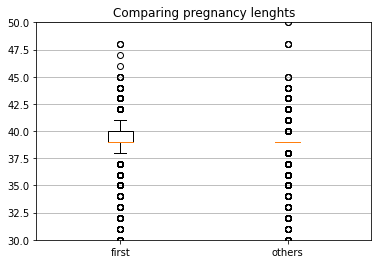

In [17]:
# Let's illustrate the percentiles with a boxplot
data = [firstbirth['prgLength'], othersbirth['prgLength']]
labels = ['first', 'others']
fig, ax = plt.subplots()
ax.set_title('Comparing pregnancy lenghts')
ax.boxplot(data,labels=labels)
ax.set_ylim(30,50)
ax.yaxis.grid(True)
plt.show()

We can numerically calculate Q1,Q2 and Q3 easily: 

In [18]:
othersbirth['prgLength'].quantile(0.25)

39.0

### 2.2 Histogram

The most common representation of a distribution is a **histogram**, which is a graph that shows the frequency of each value.

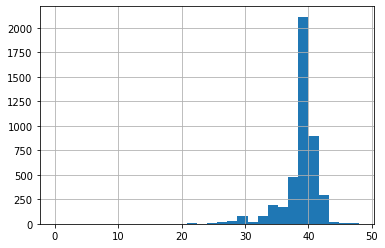

In [19]:
fb=firstbirth['prgLength']

fb.hist(density=0, histtype='stepfilled', bins=30) #no normalized, just counts

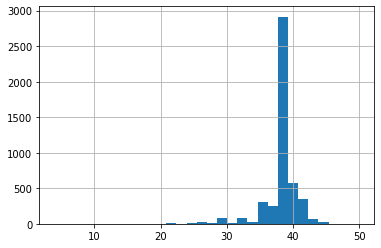

In [20]:
        
ob=othersbirth['prgLength']
ob.hist(density=0, histtype='stepfilled', bins=30)

By setting the density parameter of the histogram to 1, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

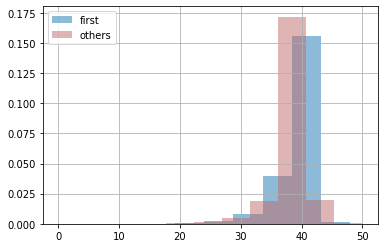

In [21]:
import seaborn as sns 
#high-level interface for drawing attractive and informative statistical graphics.

fig, ax = plt.subplots()
fb.hist(density=1, histtype='stepfilled', alpha=.5)   # normalized histogram, use default number of bins = 10
ob.hist(density=1, histtype='stepfilled', alpha=.5, color=sns.desaturate("indianred", .75))
ax.legend(['first','others'],loc='upper left')


In [22]:
import scipy.stats as stats

# Computes several descriptive statistics:
# size of the data 
# minimum and maximum value of data array
# arithmetic mean 
# unbiased variance 
# biased skewness 
# kurtosis (Fisher)

stats.describe(othersbirth['prgLength'].values)

DescribeResult(nobs=4735, minmax=(4, 50), mean=38.52291446673706, variance=6.842683519298484, skewness=-3.1536063733026825, kurtosis=20.77720107598575)

In [23]:
stats.describe(firstbirth['prgLength'].values)

DescribeResult(nobs=4413, minmax=(0, 48), mean=38.60095173351461, variance=7.794713509229203, skewness=-2.5904758400585424, kurtosis=15.132902638550163)

**Skewness** is usually described as a measure of a dataset’s symmetry – or lack of symmetry.   A perfectly symmetrical data set will have a skewness of 0.   The normal distribution has a skewness of 0. As a rule of thumb:

* If  -0.5 < skewness < 0.5 , the data are fairly symmetrical
* If  -1 < skewness < – 0.5 or 0.5 < skewness < 1, the data are moderately skewed
* If skewness < -1 or skewness > 1, the data are highly skewed


<center><img src="images/Negative_and_positive_skew.png" width="600" height="300">

In [24]:
from scipy.stats import skew
print(skew([1, 2, 3, 4, 5]))
print(skew([2, 8, 0, 4, 1, 9, 69, 0]))

0.0
2.171759931392171


**Kurtosis** defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. The normal distribution has a Kurtosis of 3 and a Kurtosis (Fisher or "excess kurtosis") of 0. 

Example: In finance, kurtosis is used as a measure of financial risk. A large kurtosis is associated with a high level of risk for an investment because it indicates that there are high probabilities of extremely large and extremely small returns. On the other hand, a small kurtosis signals a moderate level of risk because the probabilities of extreme returns are relatively low.

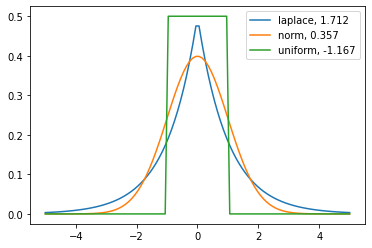

In [26]:
from scipy.stats import kurtosis
import numpy as np

x=np.linspace(-5,5,100)
ax = plt.subplot()
distnames = ['laplace','norm','uniform']

for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats,distname)(loc=-1,scale=2)#uniform distribution on [loc, loc + scale].
    else:
        dist = getattr(stats,distname)
    data = dist.rvs(size=1000)
    kur = kurtosis(data, fisher=True)
    y = dist.pdf(x)
    ax.plot(x,y,label="{}, {}".format(distname,round(kur,3)))
    ax.legend()
    


## 2.3 Data Distributions

Summarizing can be dangerous: very different data can be described by the same statistics. It must be validated by inspecting the data.

We can look at the **data distribution**, which describes how often (frequency) each value appears.


We can normalize the frequencies of the histogram by dividing/normalizing by $n$, the number of samples. The normalized histogram is called **Probability Mass Function (PMF)**.

The PMF is the probability distribution function (PDF) of a discrete random variable.

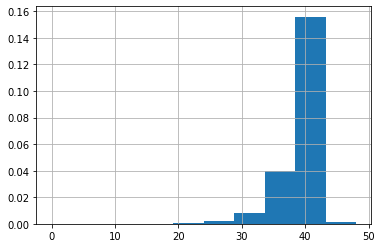

In [27]:
# if needed, execute the command 'pip install seaborn'

import seaborn as sns

fb.hist(density=1, histtype='stepfilled') # density = 1 for normalized histogram


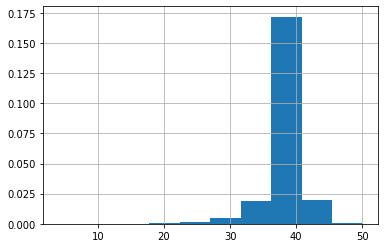

In [28]:
ob.hist(density=1, histtype='stepfilled')

The **cumulative distribution function (CDF)**, or $F_X(x)$, is defined as the probability that a real-valued random variable $X$ with a given probability distribution will be found to have a value less than or equal to $x$: 

$$F_X(x)=P(X≤x)$$

Now, let's have a look at the CDF of our two groups of data (firstborn & othersborn):

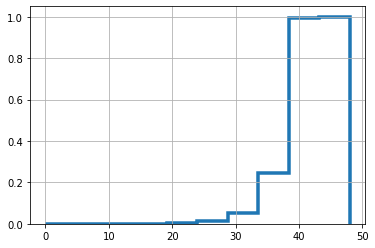

In [30]:
fb.hist(density=1, histtype='step', cumulative=True, linewidth=3.5)

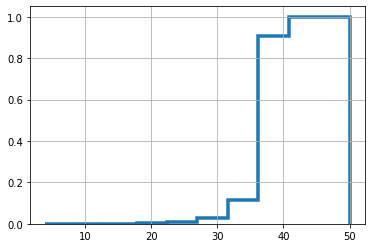

In [31]:
ob.hist(density=1, histtype='step', cumulative=True, linewidth=3.5)

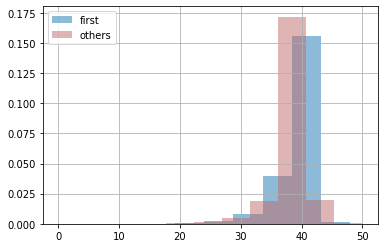

In [32]:
fig, ax = plt.subplots()
fb.hist(bins=10, density=1, histtype='stepfilled', alpha=.5) #default number of bins is 10  
ob.hist(bins=10, density=1, histtype='stepfilled', alpha=.5, color=sns.desaturate("indianred", .75))
ax.legend(['first','others'],loc='upper left')

# Check with 20, 30, 60 bins.

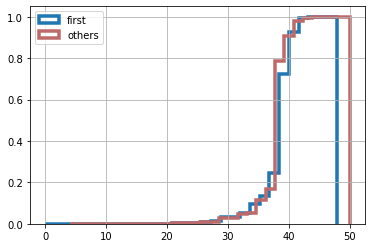

In [33]:
fig, ax = plt.subplots()
fb.hist(density=1, histtype='step', cumulative=True,  linewidth=3.5, bins=30)
ob.hist(density=1, histtype='step', cumulative=True,  linewidth=3.5, bins=30, color=sns.desaturate("indianred", .75))
ax.legend(['first','others'],loc='upper left')

# Check with 10, 60 bins.

In [34]:
print("The mean sample difference is ", fb.mean() - ob.mean(), "weeks.")

The mean sample difference is  0.07803726677754952 weeks.


## 2.4 Outliers

**Ouliers** are data samples with a value that is far from the central tendency.

We can find outliers by:

+ Computing samples that are *far* from the median.
+ Computing samples whose value *exceeds the mean* by 2 or 3 standard deviations.

This expression will return a series of boolean values that you can then index the series by:

In [35]:
(df.outcome == 1) & (df['prgLength'] < df['prgLength'].median() - 10)

0        False
1        False
2        False
3        False
4        False
         ...  
13588    False
13589    False
13590    False
13591    False
13592    False
Length: 13593, dtype: bool

In [36]:
df['prgLength'].median()

39.0

In [37]:
df[(df.outcome == 1) & (df['prgLength'] < df['prgLength'].median() - 10)]

,caseId,prgLength,outcome,birthOrd,finalWgt
138,150,9,1,6,6416.070865
157,172,24,1,1,2791.696869
237,253,28,1,1,15882.012823
541,515,18,1,2,2759.633732
628,587,24,1,1,8176.922132
...,...,...,...,...,...
12717,11737,28,1,1,10700.990760
12938,11935,28,1,1,5567.512780
13093,12078,26,1,3,10118.197375
13173,12145,22,1,1,9581.965243


In [38]:
df[(df.outcome == 1) & (df['prgLength'] > df['prgLength'].median() + 6)]

,caseId,prgLength,outcome,birthOrd,finalWgt
2416,2145,48,1,1,3770.020203
4783,4285,50,1,2,4953.764713
4920,4388,48,1,2,6484.086784
6889,6251,48,1,1,2550.828513
6890,6251,48,1,2,2550.828513
7158,6496,48,1,1,2276.785379
7161,6496,48,1,2,2276.785379
7592,6896,48,1,4,4744.403917
8998,8250,50,1,2,39510.941068
11357,10451,47,1,1,2776.806810


If we think that outliers correspond to errors, an option is to trim the data by discarting the highest and lowest values.

In [39]:
df2 = df.drop(df.index[(df.outcome == 1) & (df['prgLength'] > df['prgLength'].median() + 6)])
df2[(df2.outcome == 1) & (df2['prgLength'] > df2['prgLength'].median() + 6)] # check if removed


,caseId,prgLength,outcome,birthOrd,finalWgt


In [40]:
df3 = df2.drop(df2.index[(df2.outcome == 1) & (df2['prgLength'] < df2['prgLength'].median() - 10)])
df3[(df3.outcome == 1) & (df3['prgLength'] < df3['prgLength'].median() - 10)]

,caseId,prgLength,outcome,birthOrd,finalWgt


In [41]:
firstbirth3 = df3[(df3.outcome == 1) & (df3.birthOrd == 1)]
mu3fb = firstbirth3['prgLength'].mean()
std3fb = firstbirth3['prgLength'].std()
md3fb = firstbirth3['prgLength'].median()
print(mu3fb, std3fb, md3fb, firstbirth3['prgLength'].min(), firstbirth3['prgLength'].max())

38.76212364973569 2.307150203993601 39.0 29 45


In [42]:
othersbirth3 = df3[(df3.outcome == 1) & (df3.birthOrd >= 2)]
mu3ob = othersbirth3['prgLength'].mean()
std3ob = othersbirth3['prgLength'].std()
md3ob = othersbirth3['prgLength'].median()
print(mu3ob, std3ob, md3ob, firstbirth3['prgLength'].min(), firstbirth3['prgLength'].max())

38.658192693868834 2.0951260243080556 39.0 29 45


In [43]:
print("The mean sample difference is: ",)
print(firstbirth3['prgLength'].mean() - othersbirth3['prgLength'].mean(), "weeks.")

The mean sample difference is: 
0.10393095586685774 weeks.


Let's check the number of outliers we discarded and how it affects the data distribution:

In [44]:
print(len(df.prgLength[(df.outcome == 1)]) - len(df3.prgLength[(df3.outcome == 1)]))

116


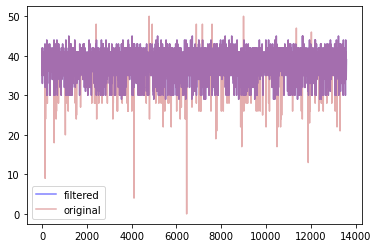

In [45]:
fig, ax = plt.subplots()
df3.prgLength[(df3.outcome == 1)].plot(alpha=.5, color='blue')
df.prgLength[(df.outcome == 1)].plot(alpha=.5, color=sns.desaturate("indianred", .95))
ax.legend(['filtered','original'])

Let's see what is happening near the mode:

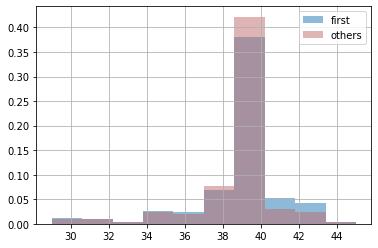

In [46]:
x = firstbirth3['prgLength']
y = othersbirth3['prgLength']

fig, ax = plt.subplots()
x.hist(density=1,alpha=.5)
y.hist(density=1,alpha=.5, color=sns.desaturate("indianred", .75))
ax.legend(['first','others'])

In [47]:
import numpy as np 

countx,divisionx = np.histogram(x) 
county,divisiony = np.histogram(y)
print (countx-county)


[   5   -2    7    5   23 -102 -509  133  108    2]


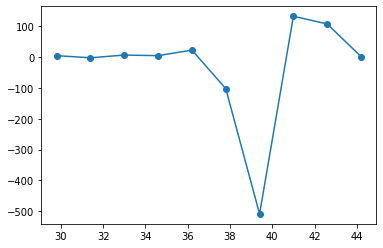

In [48]:
import matplotlib.pyplot as plt

val = [(divisionx[i]+divisionx[i+1])/2 for i in range(len(divisionx)-1)]
plt.plot(val, countx-county, 'o-') 

There is still some evidence for our hypothesis!

In [49]:
print(x.mean(), y.mean())

38.76212364973569 38.658192693868834


**Exercise**:

+ Read the file ``run10.txt`` from the ``files`` directory. It represents 16.924 runners who finished the 2012 Cherry Blossom 10 mile run in USA. The file is a ``tab``separated file. It can be read with the pandas ``read_table`` function.
+ Compute the mean time.
+ Compute the difference in mean between men and women.
+ Visualize both distributions (normalized histogram).

In [50]:
## Your solution here

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## My solution here
drun = pd.read_table('run10.txt')  
drun.head()

,place,time,pace,age,gender,location,state,divPlace,divTot
0,4494,92.25,9.225,38.0,M,Chesapeake Beach MD,MD,690.0,1093.0
1,6298,106.35,10.635,33.0,M,Washington DC,DC,1322.0,1490.0
2,2502,89.33,8.933,55.0,F,McLean VA,VA,37.0,236.0
3,8176,113.50,11.350,24.0,F,Alexandria VA,VA,878.0,974.0
4,3413,86.52,8.652,54.0,M,San Francisco CA,CA,213.0,483.0


In [4]:
drun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16924 entries, 0 to 16923
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   place     16924 non-null  int64  
 1   time      16924 non-null  float64
 2   pace      16924 non-null  float64
 3   age       16923 non-null  float64
 4   gender    16924 non-null  object 
 5   location  16924 non-null  object 
 6   state     16909 non-null  object 
 7   divPlace  16923 non-null  float64
 8   divTot    16923 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.2+ MB


Average time: 94.51919227133078
--Females: 99.01558364159473
--Males: 88.43480951056723
--Diff: -10.580774131027496


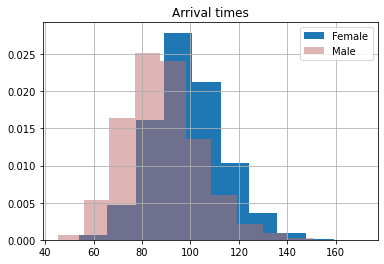

In [53]:
print('Average time:',drun['time'].mean())
females=drun[(drun.gender=='F')] 
males=drun[(drun.gender=='M')] 
print('--Females:', females['time'].mean())
print('--Males:', males['time'].mean())
print('--Diff:', males['time'].mean()-females['time'].mean())

fig, ax=plt.subplots()
females['time'].hist(density=1)
males['time'].hist(density=1, alpha=.5, color=sns.desaturate("indianred", .75))
ax.legend(['Female','Male'])
plt.title('Arrival times')
plt.show()

### 2.5 Measuring asymmetry.

**Skewness** is a statistic that measures the asymmetry of set of $n$ data samples $x_i$ but it can be affected by outliers!!! 

A more robust alternative is to look at the relationship between mean ($\mu$) median ($M_d$) and mode ($M_o$):

* If the mean is greater than the mode or median, the distribution is positively skewed.
* If the mean is less than the mode or median, the distribution is negatively skewed.



<center><img src="images/pearson-mode-skewness.jpg">

This is the intuition behind Pearson's mode ($Sk1$) and median ($Sk2$) skewness coefficients, which can be computed as:

$$ Sk1 = \frac{(\mu - M_o)}{\sigma}; \hspace{2cm}        Sk2 = \frac{3(\mu - M_d)}{\sigma} $$, 

where $sigma$ is the standard deviation of the distribution. 


**Exercise**: Compute skewness, $Sk1$ and $Sk2$ of the pregnancy length. Check impact of outliers in the metrics. 

In [54]:
## Your solution here

In [55]:
## My solution here

dorig = df.prgLength[(df.outcome == 1)]
dfilt = df3.prgLength[(df3.outcome == 1)]

## Your solution here
print(skew(dorig))
print(skew(dfilt))

#Sk1
m=dorig.mode() #returns the mode as well as the counts
print((dorig.mean()-m[0])/dorig.std())
print((dfilt.mean()-m[0])/dfilt.std())

#Sk2
print((dorig.mean()-dorig.median())/dorig.std())
print((dfilt.mean()-dfilt.median())/dfilt.std())


-2.855300690938406
-1.6136875236335502
-0.1626145101098112
-0.13259076961361363
-0.1626145101098112
-0.13259076961361363


## 2.6 Relative Risk

Let's say that a baby is "early" if it is born during week 37 or earlier, "on time" if it is born during week 38, 39 or 40, and "late" if it is born during week 41 or later. 

In [56]:
firstbirth3 = df3[(df3.outcome == 1) & (df3.birthOrd == 1)]
firstbirth3.head()

,caseId,prgLength,outcome,birthOrd,finalWgt
0,1,39,1,1,6448.271112
2,2,39,1,1,12999.542264
5,6,38,1,1,8874.440799
8,7,39,1,1,6911.879921
10,12,39,1,1,6909.331618


Let's compute the probability of being *early*, *on time* and *late* for first babies and the others.

In [57]:
print("Firsts babies: ")
Nf = len(firstbirth3.index)
print("Early",len(firstbirth3[firstbirth3['prgLength'] <38])/Nf)
print("Late", len(firstbirth3[firstbirth3['prgLength'] >40])/Nf)
print("On time", len(firstbirth3[(firstbirth3['prgLength'] >37) & (firstbirth3['prgLength'] < 41)])/Nf)

Firsts babies: 
Early 0.17191450241323833
Late 0.1565157435072397
On time 0.6715697540795219


In [58]:
print("Other babies:")
No = len(othersbirth3.index)
print("Early", len(othersbirth3[othersbirth3['prgLength'] <38])/No)
print("Late", len(othersbirth3[othersbirth3['prgLength'] >40])/No)
print("On time", len(othersbirth3[(othersbirth3['prgLength'] >37) & (othersbirth3['prgLength']<41)])/No)

Other babies:
Early 0.16000854518265328
Late 0.0935697500534074
On time 0.7464217047639393


The **relative risk** is the ratio of two probabilities. In our case, the probability that a first baby is born early is 17%. For other babies is 16%, so the relative risk is:

In [59]:
a = len(firstbirth3[firstbirth3['prgLength'] <38])/Nf
b = len(othersbirth3[othersbirth3['prgLength'] <38])/No
print(a/b)

1.074408258740145


That means that first babies are about 7% more likely to be early. For the case of late births:

In [60]:
a = len(firstbirth3[firstbirth3['prgLength'] >40])/Nf
b = len(othersbirth3[othersbirth3['prgLength'] >40])/No
print(a/b)

1.6727173409986051


That means that first babies are about 67% more likely to be late. 

### Discussions.

After exploring the data, we have seen some **apparent effects** that seem to support our first hypothesis:

+ **Data description**: The mean pregnant lenght for first babies is of 38.76 weeks and for other babies is 38.65 weeks.

+ **Relative risk**: First babies are about 67% more likely to be late.
